In [1]:
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import fiona
import pyproj
#import contextily as ctx
import os
import requests
import matplotlib.ticker as ticker
from rasterio.enums import Resampling
from affine import Affine
import shapely.geometry
import pyproj
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from itertools import combinations

from catboost import CatBoostRegressor
import seaborn as sns

/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
!pwd

/Users/amandaworthy/Paper3_map_generation


In [3]:
!ls

1_create_map_and_buffers_sample_at_sensors.ipynb
2_best_buffer_size.ipynb
3_gridding_and_modeling.ipynb
README.md
TMYx_ENG_dataset_with_optimal_buffer_lengths_for_prediction.csv
buffered_jan22_some_attributes.csv
buffered_jan22_some_attributesb4lst.csv
buffered_jan29_some_attributes.csv
buffered_jan29_some_attributesb4lst.csv


In [4]:
data_fxn = '/Users/amandaworthy/Paper3_map_generation/TMYx_ENG_dataset_with_optimal_buffer_lengths_for_prediction.csv'

df = pd.read_csv(data_fxn)

df

mygeometry_array = gpd.points_from_xy(df['Longitude (E+/W-)'], df['Latitude (N+/S-)'])

gdf= gpd.GeoDataFrame(
    df, crs='EPSG:3395', geometry=mygeometry_array)

gdf.head()

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu],streets_length_370,avg_canopy_970,mode_landcover_70,building_count_550,water_area_730,avg_lst_520
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00,730.856526,2.044056,0.0,0,0.000000,36.696189
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89,860.999766,2.092685,23.0,107,0.000072,17.799480
2,746938,47.68619,-122.2605,18.3,POINT (-122.26 47.686),51919.64,1845.552206,7.102628,24.0,13,0.000021,33.133572
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66,1946.227989,6.973427,24.0,0,0.000004,35.087714
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95,7529.461982,0.769231,24.0,39,0.000029,29.271105


In [5]:
from operator import itemgetter
import datetime as dt
# get the bounds of the seattle city limits 
start = dt.datetime.now()

bounds = gdf.geometry.apply(lambda x: x.bounds).tolist()

minx, miny, maxx, maxy = min(bounds, key=itemgetter(0))[0], min(bounds, key=itemgetter(1))[1], max(bounds, key=itemgetter(2))[2], max(bounds, key=itemgetter(3))[3] #https://stackoverflow.com/questions/13145368/find-the-maximum-value-in-a-list-of-tuples-in-python
print(minx, miny, maxx, maxy)

-122.4353 47.444 -122.214 47.68619


In [6]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer

def create_grid(minx, miny, maxx, maxy, grid_size):
    grid_cells = []
    x_range = range(int(minx-0.1), int(maxx+0.1), grid_size)
    y_range = range(int(miny-0.1), int(maxy+0.1), grid_size)
    
    for x in x_range:
        for y in y_range:
            grid_cells.append(Polygon([(x, y), (x + grid_size, y), (x + grid_size, y + grid_size), (x, y + grid_size)]))
    
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='EPSG:3857')
    return grid

# Define the bounding box in geographic coordinates (longitude, latitude)
minx, miny, maxx, maxy = -122.43595589761995, 47.495513623976045, -122.23604445458422, 47.734164946845

# Create a transformer to convert from EPSG:4326 to EPSG:3857
transformer = Transformer.from_crs(CRS("EPSG:4326"), CRS("EPSG:3857"), always_xy=True)

# Transform the bounding box coordinates to EPSG:3857
minx_proj, miny_proj = transformer.transform(minx, miny)
maxx_proj, maxy_proj = transformer.transform(maxx, maxy)

# Grid size of 2000 meters
grid_size = 100 #can change

# Create the grid
grid_gdf = create_grid(minx_proj, miny_proj, maxx_proj, maxy_proj, grid_size)

# Optionally, convert the grid back to the original CRS
grid_gdf = grid_gdf.to_crs(epsg=4326)

# Extract bounds (minx, miny, maxx, maxy) for each grid cell and add them as columns
grid_gdf['min_lon'] = grid_gdf['geometry'].bounds.minx
grid_gdf['min_lat'] = grid_gdf['geometry'].bounds.miny
grid_gdf['max_lon'] = grid_gdf['geometry'].bounds.maxx
grid_gdf['max_lat'] = grid_gdf['geometry'].bounds.maxy

grid_gdf

,geometry,min_lon,min_lat,max_lon,max_lat
0,"POLYGON ((-122.43595 47.49551, -122.43506 47.4...",-122.435954,47.495508,-122.435055,47.496115
1,"POLYGON ((-122.43595 47.49612, -122.43506 47.4...",-122.435954,47.496115,-122.435055,47.496722
2,"POLYGON ((-122.43595 47.49672, -122.43506 47.4...",-122.435954,47.496722,-122.435055,47.497329
3,"POLYGON ((-122.43595 47.49733, -122.43506 47.4...",-122.435954,47.497329,-122.435055,47.497936
4,"POLYGON ((-122.43595 47.49794, -122.43506 47.4...",-122.435954,47.497936,-122.435055,47.498543
...,...,...,...,...,...
88080,"POLYGON ((-122.23653 47.73168, -122.23563 47.7...",-122.236528,47.731683,-122.235629,47.732287
88081,"POLYGON ((-122.23653 47.73229, -122.23563 47.7...",-122.236528,47.732287,-122.235629,47.732892
88082,"POLYGON ((-122.23653 47.73289, -122.23563 47.7...",-122.236528,47.732892,-122.235629,47.733496
88083,"POLYGON ((-122.23653 47.7335, -122.23563 47.73...",-122.236528,47.733496,-122.235629,47.734100


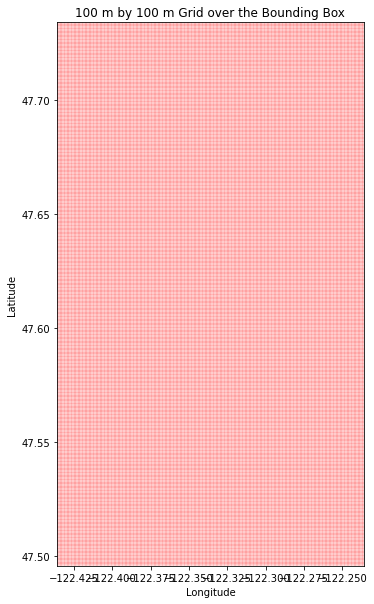

In [10]:
# Plot the grid
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.1)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 m by 100 m Grid over the Bounding Box")
#plt.title("100m by 100m Grid over the Bounding Box")
plt.show()

In [7]:
gdf.columns

Index(['WMO', 'Latitude (N+/S-)', 'Longitude (E+/W-)', 'Elevation (m)',
       'geometry', 'Total Energy [kBtu]', 'streets_length_370',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_550',
       'water_area_730', 'avg_lst_520'],
      dtype='object')

In [8]:
gdf

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu],streets_length_370,avg_canopy_970,mode_landcover_70,building_count_550,water_area_730,avg_lst_520
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00,730.856526,2.044056,0.0,0,0.000000,36.696189
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89,860.999766,2.092685,23.0,107,0.000072,17.799480
2,746938,47.68619,-122.2605,18.3,POINT (-122.26 47.686),51919.64,1845.552206,7.102628,24.0,13,0.000021,33.133572
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66,1946.227989,6.973427,24.0,0,0.000004,35.087714
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95,7529.461982,0.769231,24.0,39,0.000029,29.271105
5,994350,47.66200,-122.4353,3.0,POINT (-122.435 47.662),49613.79,188.386766,2.894056,31.0,0,0.000077,17.161170
6,727935,47.53000,-122.3010,6.0,POINT (-122.301 47.53),50751.23,0.000000,2.687855,23.0,12,0.000000,37.318259


<AxesSubplot:>

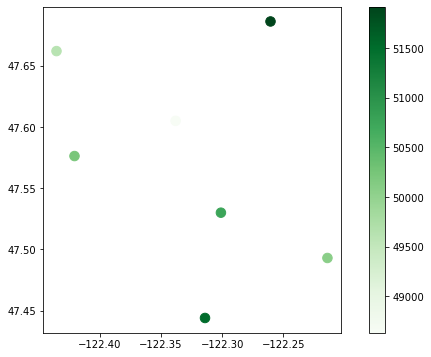

In [9]:
# Plot the GeoDataFrame
gdf.plot(column='Total Energy [kBtu]', marker='o', cmap='Greens', 
         legend=True, markersize=90, figsize=(10, 6))

In [11]:
features = ['Elevation (m)', 'streets_length_370',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_550',
       'water_area_730', 'avg_lst_520' ]


target = 'Total Energy [kBtu]'

gdf = gdf.dropna(subset=features + [target])

X= gdf[features]
y= gdf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=21)



# Output shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (6, 7)
X_test shape: (1, 7)
y_train shape: (6,)
y_test shape: (1,)


In [12]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Make predictions
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)

# Calculate RMSE and R² for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R² for the testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Report the results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")

Training RMSE: 441.92
Testing RMSE: 288.48
Training R²: 0.84
Testing R²: nan


/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


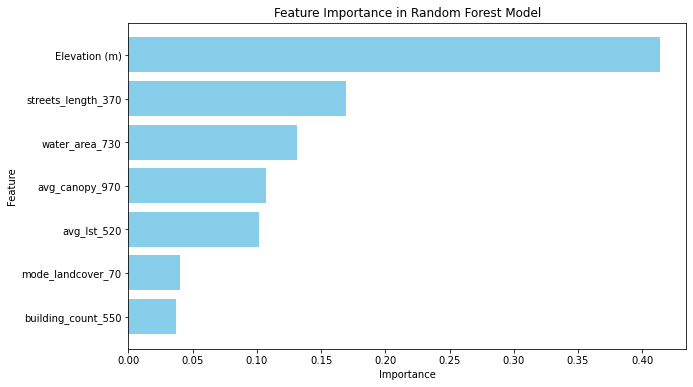

In [13]:
# Extract feature importances
importances = RF_model.feature_importances_
features= RF_model.feature_names_in_

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [15]:
# add water varaibels into here 
target = 'Total Energy [kBtu]'

X_grid = grid_gdf[features]

y_grid_RF = RF_model.predict(X_grid)

grid_gdf['aq_pred_RF']= y_grid_RF

KeyError: "None of [Index(['Elevation (m)', 'streets_length_370', 'avg_canopy_970',\n       'mode_landcover_70', 'building_count_550', 'water_area_730',\n       'avg_lst_520'],\n      dtype='object')] are in the [columns]"

In [28]:
grid_gdf.head()

,geometry,min_lon,min_lat,max_lon,max_lat
0,"POLYGON ((-122.43595 47.49551, -122.43506 47.4...",-122.435954,47.495508,-122.435055,47.496115
1,"POLYGON ((-122.43595 47.49612, -122.43506 47.4...",-122.435954,47.496115,-122.435055,47.496722
2,"POLYGON ((-122.43595 47.49672, -122.43506 47.4...",-122.435954,47.496722,-122.435055,47.497329
3,"POLYGON ((-122.43595 47.49733, -122.43506 47.4...",-122.435954,47.497329,-122.435055,47.497936
4,"POLYGON ((-122.43595 47.49794, -122.43506 47.4...",-122.435954,47.497936,-122.435055,47.498543
